In [246]:
# file = 'wgetthinkbroadband_hourGrouping.csv'
file = 'datacollectorr_amazon_hourGrouping.csv'
# file = 'curltxt_hourGrouping.csv'
# file = 'datacollectorr_hourGrouping.csv'
# file = 'Snowflake_dayGrouping.csv'


#Custom function to generate missing entries in the time serie 
import datetime
import collections
import numpy as np

# base = datetime.datetime.today()
base = datetime.datetime(2019, 1, 1)
date_list = [base + datetime.timedelta(hours=x) for x in range((24*30*5) + 13)]
di = collections.defaultdict(int)
for t in date_list:
#     print(t.strftime("%Y-%m-%d %H:%M:%S.000"))
    di[t.strftime("%Y-%m-%d %H:%M:%S.000")] = 0
    

with open('datasets_byhour_raw/'+file) as f:
    ts_array = f.readline()
    ts_array = f.readlines()
def transform(ts_str):
    entity_dict = {}
    temp_array = ts_str.split(',')
    date =  temp_array[0]
    di[date] = float(temp_array[3])  
#     return di

for x in ts_array:
    transform(x)
    
# we want to save it to open it with JMP and visualize it easier.
time_series = list(di.values())
# np.savetxt('datasets_byhour/'+file, time_series, delimiter=',')

/Users/anglecambero/anaconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Plot of the number of connections between processes and dns by day')

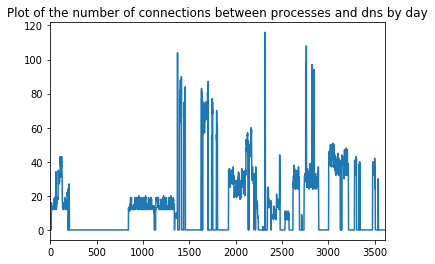

In [247]:
import seaborn as sns
import matplotlib.pyplot as plot
sns.tsplot(time_series)
plot.title("Plot of the number of connections between processes and dns by day") 

In [248]:
class Algorithm():
    
    # Constants 
    trainingTime = 30 * 24
    timeLast60days = 60 * 24
    timeLast30days = 30 * 24
    timeLast15days = 15 * 24
    timeLast5days  = 5 * 24
    timeLast1days  = 24
    timeLast5hours = 5
    
    # Results       
    trackAllSpikesValue = []
    trackAllSpikesPosition = []
    rareEdgesTrack = {
                        'positions': [], 
                        'values': [], 
                        'stdPrev15days': [], 
                        'distPrevRareEdge': [], 
                        'continuousZeroPrevRareEdge': [],
                        'reportedRareEdge': []
                    }
    
        
    def rareEdge_detection(self, ts):

        # Initializations
        flag = False
        spike = False
        timeSerieHours = len(ts)
        assert timeSerieHours > 30, "not enough data"
        

        # Training first 30 days
        self.rareEdgesTrack['positions'].append(self.trainingTime - 1)
        self.rareEdgesTrack['values'].append(np.amax(ts[:self.trainingTime]))
        self.rareEdgesTrack['reportedRareEdge'].append(False)
        trackAllSpikesValue.append(np.amax(ts[:self.trainingTime]))
        trackAllSpikesPosition.append(self.trainingTime - 1)
        

        # Training & Detection
        for i in range(self.trainingTime, timeSerieHours):

            # No need to process zeros
            if ts[i] == 0:
                continue

            # Distance from last Rare Edge 
            timeSinceLastRE = i - self.rareEdgesTrack['positions'][-1]
             
            # Reset Flags
            flag = False
            toReport = False
        
            # Heuristics to detect Rare edges
            if (timeSinceLastRE > self.timeLast60days and ts[i] > np.mean(self.rareEdgesTrack['values']) * 0.50) or \
               (timeSinceLastRE > self.timeLast30days and timeSinceLastRE < self.timeLast60days and self.rareEdgesTrack['values'][-1] * 1.50 < ts[i]) or \
               (timeSinceLastRE > self.timeLast15days and timeSinceLastRE < self.timeLast30days and self.rareEdgesTrack['values'][-1] * 2 < ts[i]) or \
               (timeSinceLastRE > self.timeLast5days and timeSinceLastRE < self.timeLast15days and self.rareEdgesTrack['values'][-1] * 3 < ts[i]) or \
               (timeSinceLastRE > self.timeLast1days and timeSinceLastRE < self.timeLast5days and self.rareEdgesTrack['values'][-1] * 5 < ts[i]):
                self.rareEdgesTrack['values'].append(ts[i])
                self.rareEdgesTrack['positions'].append(i)
                toReport = True
         
        
            # 24 hours after an rare edge, rare edge is updated but no reported again.
            if (timeSinceLastRE < self.timeLast1days and self.rareEdgesTrack['values'][-1] < ts[i]):
                self.rareEdgesTrack['values'].append(ts[i])
                self.rareEdgesTrack['positions'].append(i)
                toReport = False
                
                
            # Rare edges should be greater than 3 times the spikes from the last rare edge
            if ts[i] < (np.mean([value for posValue, value in enumerate(trackAllSpikesValue) if trackAllSpikesPosition[posValue] < timeSinceLastRE])) * 3:
                toReport = False
          
            # Check agsinst spikes
            theValues = [trackAllSpikesValue[position] for position in trackAllSpikesPosition if position < timeSinceLastRE]
            if len(theValues) > 0 and ts[i] < np.max(theValues) * 1.50:
                toReport = False

    
            if(toReport):
                self.rareEdgesTrack['reportedRareEdge'].append(toReport)
                print("Rare Edge at ",i," hour: ", ts[i], " connections")
            
            # A spike is at least 50% of the last of rare edge
            if ts[i] > self.rareEdgesTrack['values'][-1] * 0.75:
                trackAllSpikesValue.append(ts[i])
                trackAllSpikesPosition.append(i)
                
        return (trackAllSpikesPosition, trackAllSpikesValue)    

trackAllSpikesPosition, trackAllSpikesValue = Algorithm().rareEdge_detection(time_series)

Rare Edge at  1374  hour:  104.0  connections


In [ ]:
# for index in range(0,len(trackAllSpikesValue)):
#     print(trackAllSpikesPosition[index], '-->', trackAllSpikesValue[index])